In [1]:
from pringles.simulator import Simulator
mySimulator = Simulator(cdpp_bin_path='bin/', user_models_dir='src/')

In [2]:
atomics = dict([(atomic.__name__, atomic) for atomic in mySimulator.atomic_registry.discovered_atomics])
Server = atomics['Server']
Dispatcher = atomics['Dispatcher']
ServerQueue = atomics['ServerQueue']
Generator = atomics['Generator']
Attacker = atomics['Attacker']
AutoScaler = atomics['AutoScaler']
print(Server)
print(Dispatcher)
print(ServerQueue)
print(Attacker)
print(Generator)

<class 'pringles.models.models.Server'>
<class 'pringles.models.models.Dispatcher'>
<class 'pringles.models.models.ServerQueue'>
<class 'pringles.models.models.Attacker'>
<class 'pringles.models.models.Generator'>


In [3]:
number_of_servers = 10


autoScalerDefaultConfig = {
    'numberOfServers': number_of_servers,
    'exponentialWeight' : 0.6,
    'loadLowerBound': 0.3,
    'loadUpperBound': 0.8,
    'loadUpdatesToBreakIdle': 300,
    'server0': 'free',
}


dispatcherDefaultConfig = {
    'numberOfServers': number_of_servers,
    'server0': 'free'
}


serverDefaultConfig = {
    'distribution': 'exponential',
    'mean': .25,
    'setupTime': '00:00:05:00'
}

normalTrafficGenDefaultConfig = {
    'distribution': 'normal',
    'mean': 0.001,
    'deviation': 1,
    'initial': 0,
    'increment': 1
}

serverOnDefaultConifg = {
    'initialStatus': 'free',
    **serverDefaultConfig
}

serverOffDefaultConifg = {
    'initialStatus': 'off',
    **serverDefaultConfig
}

serverQueueDefaultConfig = {
    'size': 1000,
    'currentSizeFrequency': '00:00:00:10'
}

attackerDefaultConfig = {
    'file': '../../attack-data/ataque.txt'
}

normalTrafficGenDefaultConfig = {
    'distribution': 'normal',
    'mean': 0.01,
    'deviation': 0.1,
    'initial': 0,
    'increment': 1
}

In [4]:
from pringles.models.errors import PortNotFoundException

scaler = AutoScaler('autoscaler', **autoScalerDefaultConfig)
dispatcher = Dispatcher('dispatcher', **dispatcherDefaultConfig)
queue = ServerQueue('queue', **serverQueueDefaultConfig)
trafficGenerator = Generator('gen', **normalTrafficGenDefaultConfig)
attacker = Attacker('attacker', **attackerDefaultConfig)

for i in range(number_of_servers):
    server_name = "server" + str(i)
    try:
        dispatcher.get_port(server_name)
    except PortNotFoundException:
        dispatcher.add_outport(server_name)

In [5]:
from pringles.models import Coupled
from pringles.simulator import Simulation, Event
from pringles.utils import VirtualTime

server_means = [0.5, 0.7, 0.75, 0.78, 0.8, 0.9]
results = {}

for mean in server_means:
    serverOnConfig = serverOnDefaultConifg.copy()
    serverOnConfig["mean"] = mean
    
    serverOffConfig = serverOffDefaultConifg.copy()
    serverOffConfig["mean"] = mean
    
    server0 = Server('server0', **serverOnConfig)
    server1 = Server('server1', **serverOffConfig)
    server2 = Server('server2', **serverOffConfig)
    server3 = Server('server3', **serverOffConfig)
    server4 = Server('server4', **serverOffConfig)
    server5 = Server('server5', **serverOffConfig)
    server6 = Server('server6', **serverOffConfig)
    server7 = Server('server7', **serverOffConfig)
    server8 = Server('server8', **serverOffConfig)
    server9 = Server('server9', **serverOffConfig)


    subcomponents = [
        dispatcher,
        queue,
        scaler,
        trafficGenerator,
        server0,
        server1,
        server2,
        server3,
        server4,
        server5,
        server6,
        server7,
        server8,
        server9    
    ]

    top_model = (
        Coupled(name='top', subcomponents=subcomponents)
            .add_outport('processedJob')
            .add_outport('droppedJob')
            .add_outport('loadAvg')
            #GENERATOR OUT
            .add_coupling(trafficGenerator.get_port('out'), queue.get_port('in'))
            #QUEUE OUT
            .add_coupling(queue.get_port('out'), dispatcher.get_port('newJob'))
            .add_coupling(queue.get_port('queueLoad'), scaler.get_port('queueLoad'))
            .add_coupling(queue.get_port('discarded'), 'droppedJob')
            .add_coupling(queue.get_port('loadAvg'), 'loadAvg')
            #DISPATCHER OUT
            .add_coupling(dispatcher.get_port('requestJob'), queue.get_port('emit'))
            .add_coupling(dispatcher.get_port('server0'), server0.get_port('job'))
            .add_coupling(dispatcher.get_port('server1'), server1.get_port('job'))
            .add_coupling(dispatcher.get_port('server2'), server2.get_port('job'))
            .add_coupling(dispatcher.get_port('server3'), server3.get_port('job'))
            .add_coupling(dispatcher.get_port('server4'), server4.get_port('job'))
            .add_coupling(dispatcher.get_port('server5'), server5.get_port('job'))
            .add_coupling(dispatcher.get_port('server6'), server6.get_port('job'))
            .add_coupling(dispatcher.get_port('server7'), server7.get_port('job'))
            .add_coupling(dispatcher.get_port('server8'), server8.get_port('job'))
            .add_coupling(dispatcher.get_port('server9'), server9.get_port('job'))
            #SCALER OUT
            .add_coupling(scaler.get_port('server0'), server0.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server1'), server1.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server2'), server2.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server3'), server3.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server4'), server4.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server5'), server5.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server6'), server6.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server7'), server7.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server8'), server8.get_port('powerSignal'))
            .add_coupling(scaler.get_port('server9'), server9.get_port('powerSignal'))
            .add_coupling(scaler.get_port('serverStatus'), dispatcher.get_port('serverStatus'))
            #SERVER OUT
            .add_coupling(server0.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server1.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server2.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server3.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server4.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server5.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server6.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server7.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server8.get_port('done'), dispatcher.get_port('jobDone'))
            .add_coupling(server9.get_port('done'), dispatcher.get_port('jobDone'))

            .add_coupling(server0.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server1.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server2.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server3.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server4.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server5.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server6.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server7.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server8.get_port('ready'), scaler.get_port('serverResponse'))
            .add_coupling(server9.get_port('ready'), scaler.get_port('serverResponse'))

            .add_coupling(server0.get_port('done'), 'processedJob')
            .add_coupling(server1.get_port('done'), 'processedJob')
            .add_coupling(server2.get_port('done'), 'processedJob')
            .add_coupling(server3.get_port('done'), 'processedJob')
            .add_coupling(server4.get_port('done'), 'processedJob')
            .add_coupling(server5.get_port('done'), 'processedJob')
            .add_coupling(server6.get_port('done'), 'processedJob')
            .add_coupling(server7.get_port('done'), 'processedJob')
            .add_coupling(server8.get_port('done'), 'processedJob')
            .add_coupling(server9.get_port('done'), 'processedJob')

    )

    a_simulation = Simulation(
        top_model = top_model, 
        duration = VirtualTime.of_minutes(15),
        working_dir='sim_results/alterando-lambda'
    )

    results[str(mean)] = mySimulator.run_simulation(a_simulation)
    results[str(mean)].logs_dfs['autoscaler'].insert(2, "simu_id", "media_" + str(mean))

In [9]:
df = results[str(server_means[0])].logs_dfs["autoscaler"][500:]
for mean in server_means[1:]:
    df = df.append(results[str(mean)].logs_dfs["autoscaler"][500:])

In [10]:
df = results[str(server_means[0])].logs_dfs["autoscaler"]
for mean in server_means[1:]:
    df.append(results[str(mean)].logs_dfs["autoscaler"])
    
df

,0,1,simu_id,message_type,time,model_origin,port,value,model_dest
0,0,L,media_0.5,X,00:00:00:000,top(15),queueload,0.001,autoscaler(03)
1,0,L,media_0.5,X,00:00:00:010,top(15),queueload,0.000,autoscaler(03)
2,0,L,media_0.5,X,00:00:00:020,top(15),queueload,0.000,autoscaler(03)
3,0,L,media_0.5,X,00:00:00:030,top(15),queueload,0.000,autoscaler(03)
4,0,L,media_0.5,X,00:00:00:040,top(15),queueload,0.001,autoscaler(03)
5,0,L,media_0.5,X,00:00:00:050,top(15),queueload,0.001,autoscaler(03)
6,0,L,media_0.5,X,00:00:00:060,top(15),queueload,0.001,autoscaler(03)
7,0,L,media_0.5,X,00:00:00:070,top(15),queueload,0.001,autoscaler(03)
8,0,L,media_0.5,X,00:00:00:080,top(15),queueload,0.001,autoscaler(03)
9,0,L,media_0.5,X,00:00:00:090,top(15),queueload,0.001,autoscaler(03)


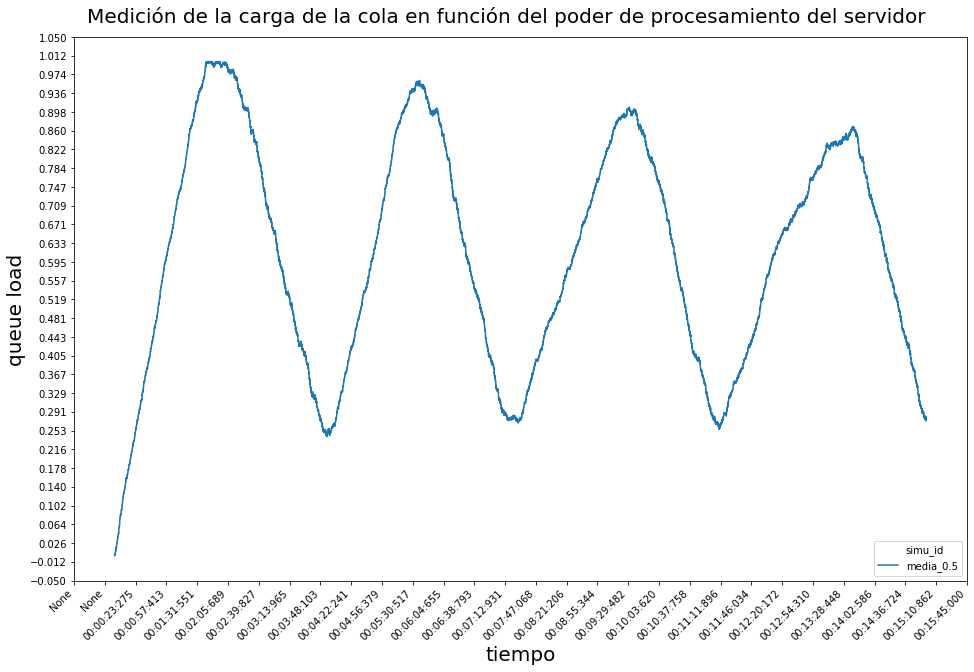

In [11]:
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from pringles.utils import vtime_decorate, VirtualTime

df_res = df[df["port"] == 'queueload'][["time", "value", "simu_id"]]
plt.figure(figsize=(16, 10))

ax2 = sns.lineplot(x='time', y='value', data=df_res, hue="simu_id")
ax2 = vtime_decorate(ax2)
ax2.xaxis.set_major_locator(ticker.LinearLocator(30))
ax2.yaxis.set_major_locator(ticker.LinearLocator(30))
ax2.yaxis.legend = "queueload"
ax2.set_ylabel("queue load", fontsize=20)
ax2.set_xlabel("tiempo", fontsize=20)
plt.figtext(.5,.9,"Medición de la carga de la cola en función del poder de procesamiento del servidor", fontsize=20, ha='center')
plt.xticks(rotation=45, ha='right')
plt.legend(loc="lower right")
plt.savefig("report/img/server_capacity.png")
plt.show()